# Figure 4b and Supplementary Figures 4a and 4b

## Install and read the R packages

In [ ]:
install.packages("data.table")
library(data.table)
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



## Download and read the fitted parameters of the non homogeneous Poission process model in Figure 4b and Supplementary Figures 4a and 4b

In [ ]:
system("wget https://www.dropbox.com/s/v993wf5p22gz7kc/fig4.zip")
system("unzip /content/fig4.zip")
df <- fread("/content/fig4/fig4_non_homogeneous_poisson_process_result.tsv")
id <- which(df$value[df$param!="a"]<0)
df$value[(df$param!="a")][id] <- - df$value[(df$param!="a")][id]
df$sample_id <- as.numeric(sapply(strsplit(df$sample,"_"),function(x){x[2]}))

In [ ]:
unique_param <- unique(df$param)
unique_area <- unique(df$"14area"[df$"14area"!=""])
unique_sample_id <- sort(unique(df$sample_id))
score1 <- score2 <- matrix(0,length(unique_param),length(unique_area))
pval2 <- matrix(1,length(unique_param),length(unique_area))
for(i in 1:length(unique_param)){
  for(j in 1:length(unique_area)){
      id <- which(unique_param[i]==df$param&unique_area[j]==df$"14area")
      d <- df[id,]
      case <- grep("SMA",d$sample)
      control <- grep("VE-cad",d$sample)
      d1 <- d[case,]
      d2 <- d[control,]
      dd <- d1 %>% inner_join(d2,by=c("id","sample_id"))
      score1[i,j] <- sum(dd$value.x / dd$value.y >= 2)
      score2[i,j] <- sum(dd$value.x / dd$value.y < 2)
      pval2[i,j] <- t.test(dd$value.x,dd$value.y,alternative="greater",paired=TRUE)$p.value
  }
}
pval <- matrix(1,length(unique_param),length(unique_area))
for(i in 1:length(unique_param)){
  for(j in 1:length(unique_area)){
    a11 <- score1[i,j]
    a21 <- score2[i,j]
    a12 <- sum(score1[i,-j])
    a22 <- sum(score2[i,-j])
    pval[i,j] <- fisher.test(matrix(c(a11,a21,a12,a22),ncol=2))$p.value
  }
}
dimnames(pval) <- dimnames(pval2) <- list(unique_param,unique_area)


## Supplementary Figure 4a

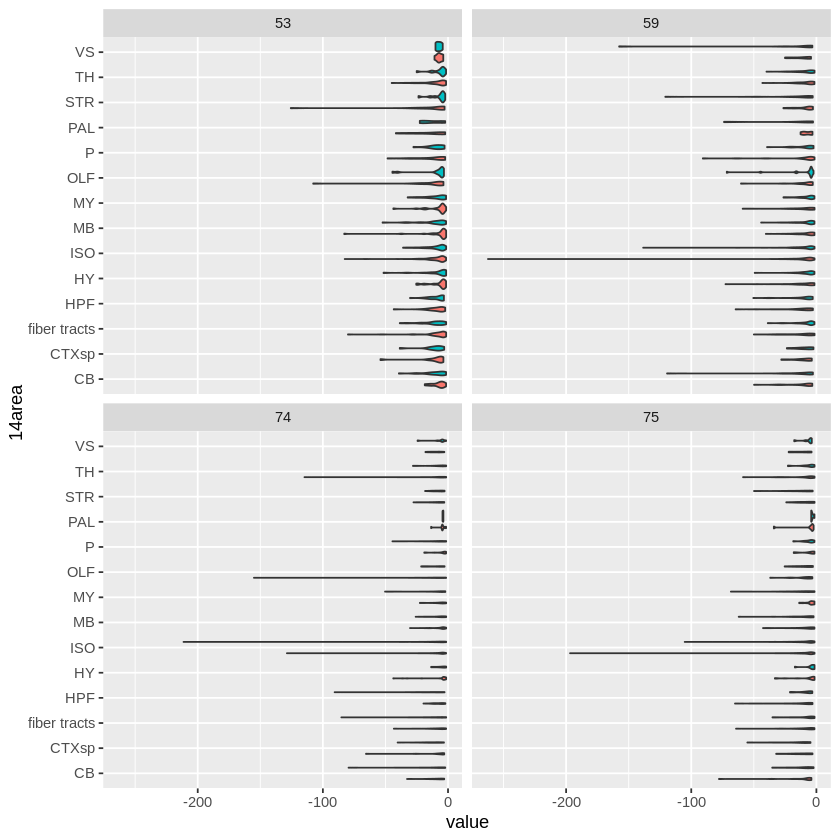

In [ ]:
type <- rep("SMA",nrow(df))
type[grep("VE-cad",df$sample)] <- "VE-cad"
d <- cbind(df,type=factor(type,level=c("VE-cad","SMA")))

dd <- d[d$param=="a"&d$`14area`!="",]
write.table(dd,"suppl_fig4a.tsv",row.names=FALSE,col.names=TRUE,sep="\t",quote=FALSE)
g <- ggplot(dd, aes(x = `14area`, y = value))
g <- g + geom_violin(aes(fill=factor(type))) +  facet_wrap(vars(sample_id)) +
theme(legend.position="none") +
coord_flip()

g

## Supplementary Figure 4b

Warning message:
“Removed 516 rows containing non-finite values (stat_ydensity).”


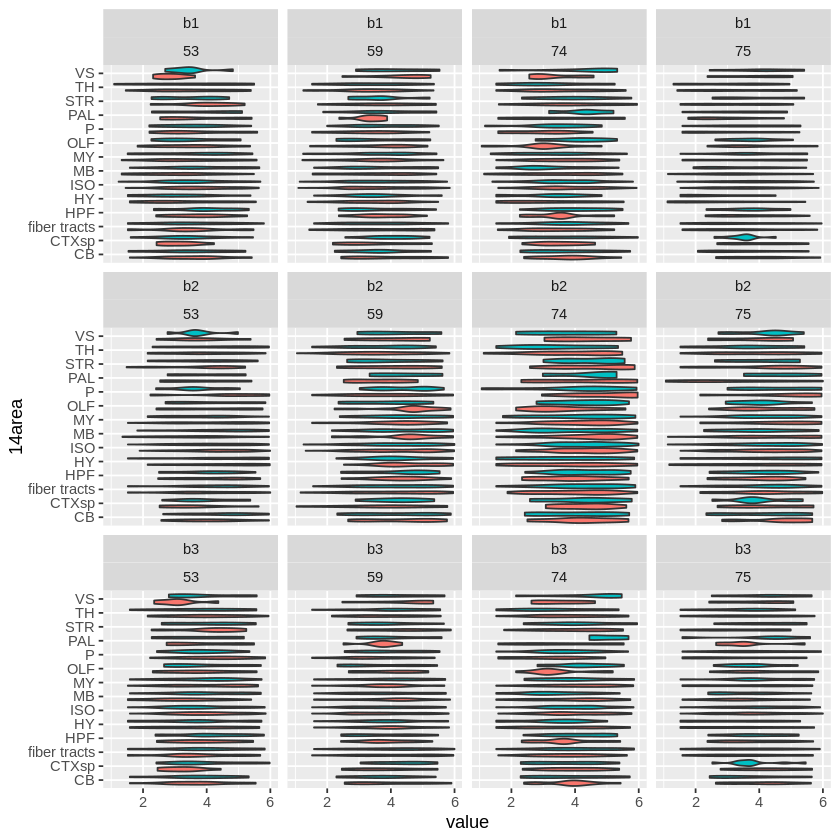

In [ ]:
dd <- d[d$param!="a" & d$`14area`!="",]
write.table(dd,"suppl_fig4b.tsv",row.names=FALSE,col.names=TRUE,sep="\t",quote=FALSE)
g <- ggplot(dd, aes(x = `14area`, y = value))
g <- g + geom_violin(aes(fill=factor(type))) +  facet_wrap(vars(param,sample_id)) +
ylim(1,6) +
theme(legend.position="none") +
coord_flip()

g

## Figure 4b

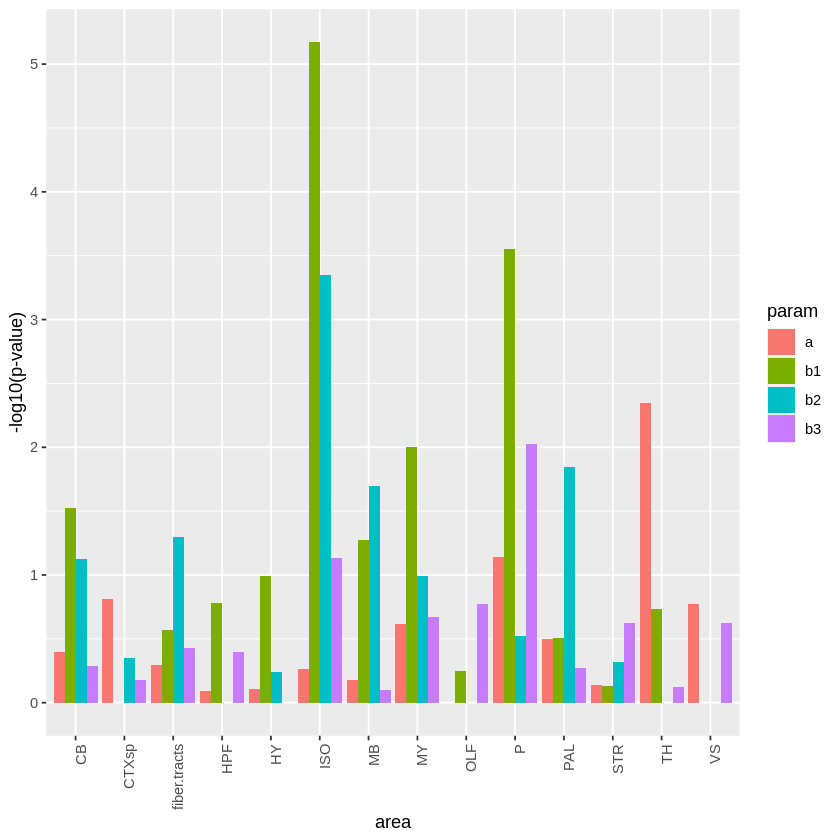

In [ ]:
df <- data.frame(pval) %>% rownames_to_column(var="param") %>% pivot_longer(cols=2:(ncol(pval)+1))
write.table(df,"fig4b.tsv",row.names=FALSE,col.names=TRUE,sep="\t",quote=FALSE)
g <- ggplot(data=df, aes(x=name, y=-log10(value), fill=param)) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
geom_bar(stat="identity", position=position_dodge()) + xlab("area") + ylab("-log10(p-value)")
g